# Structures of missing data: A simple monotone pattern

This example shows how to investigate patterns of missing data in a simple dataset. The dataset has five variables (M1 to M5). M1 is empty (i.e., it does not contain any values), M5 is complete, and M2, M3 and M4 are partially missing.

## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from vizdataquality import plot as vdqp
from vizdataquality import missing_data_functions as mdf, missing_data_plots as mdp, missing_data_utils as mdu
from vizdataquality import explanation_graph as eg

## Create the dataframe

In [2]:
num_rows = 1000
num_missing_values = [0, int(num_rows*4/10), int(num_rows*7/10), int(num_rows*9/10), num_rows]
value = 'x'
data = {}

for l1 in range(len(num_missing_values)):
    num = num_missing_values[l1]
    
    if num == 0:
        data['M' + str(l1+1)] = [value] * num_rows
    elif num == num_rows:
        data['M' + str(l1+1)] = [np.nan] * num
    else:
        data['M' + str(l1+1)] = [np.nan] * num + [value] * (num_rows - num)

df = pd.DataFrame.from_dict(data)
# Number of records in the dataset
num_records = len(df)

## Compute the missingness data structures

The data structures (data types) are as follows:
- num_missing (Series): The number of missing values in each variable.
- intersection_id_to_columns (DataFrame): A row for each combination of missing/present variables, and a column for each variable (set to True if value is missing, or False if value is present in that combination).
- intersection_id_to_records (DataFrame): A row for each record. The index is an intersection ID (usually not unique) and the column contains a record ID (not in any particular order).
- intersection_cardinality (Series): Series that contains the count for each intersection (i.e., the number of records that are missing that combination of variables).

In [3]:
num_missing, intersection_id_to_columns, intersection_id_to_records = mdf.get_intersections_from_dataframe(df)
intersection_cardinality = mdf.get_intersection_cardinality(intersection_id_to_records)

## Plot overview of missingness in dataset as a whole

One variable is complete (M1), one is empty (M5), and the other three are partially missing (M2, M3 and M4). Overall, 1000 values are missing from the empty variable (M5) and 2000 values are missing from the partially missing variables (M2, M3 and M4). A total of 2000 values are present (in variables M1, M2, M3 and M4).

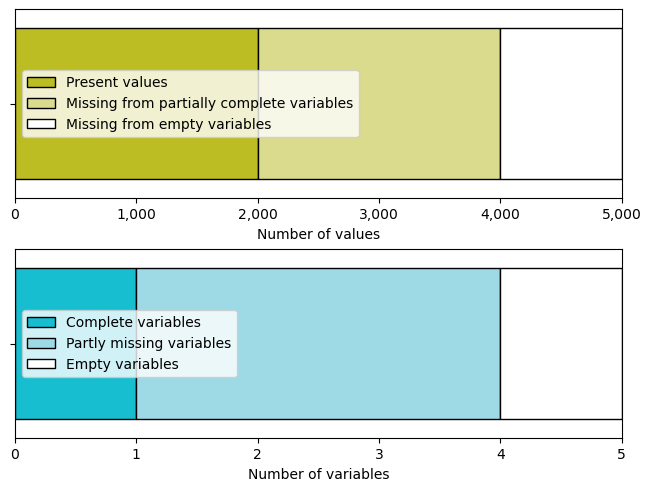

In [4]:
fig_kw = {'constrained_layout': True}
# Adjust the position and size of the legend
legend_kw = {'loc': 'center left', 'bbox_to_anchor': (0.0, 0.5)}
mdp.plot_summary_missingness(num_records, num_missing, num_rows=2, vert=False, fig_kw=fig_kw, legend_kw=legend_kw)

## Plot the number of missing values for each variable

Progressively more values are missing as we go from variable M1 to M5.

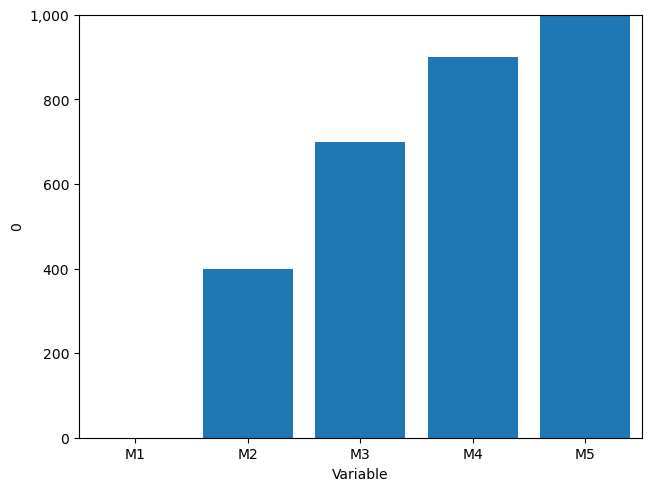

In [5]:
fig_kw = {'constrained_layout': True}
ax_kw = {'ylim': (0, num_records)}
vdqp.scalar_bar(num_missing, vert=True, fig_kw=fig_kw, ax_kw=ax_kw)

## Visualize the combinations of missing values

The bar chart above looks like a staircase, which suggests that there might be a monotone pattern of missing values but we can only be certain by investigating the combinations of missing values.

The heatmap shows the combinations of missing values, and confirms that it is a monotone pattern. I.e.:
- If M2 is missing then M3, M4 and M5 are also always missing.
- If M3 is missing then M4 and M5 are also always missing.
- If M4 is missing then M5 is also always missing.
- M5 is sometimes missing by itself.

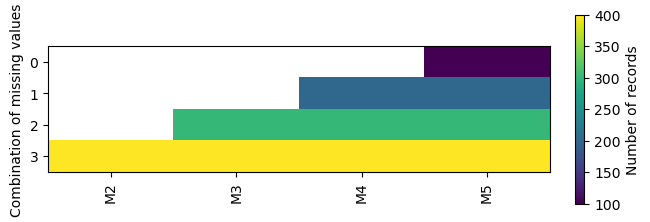

In [6]:
dftmp = mdf.get_intersection_heatmap_data(intersection_id_to_columns, intersection_cardinality)
# Sort the heatmap so the combinations are in ascending cardinality order
dftmp['_max'] = dftmp.max(axis=1)
df_heatmap = dftmp.sort_values(by='_max').drop(columns='_max')

fig_kw = {'constrained_layout': True}#, 'size_inches': (colwidth, 4)}
ax_kw = {'ylabel': 'Combination of missing values'}
#cbar_kw = {'location': 'top', 'label': 'Number of records', 'shrink': 0.6}
cbar_kw = {'label': 'Number of records', 'shrink': 0.4}

mdp.plot_intersection_heatmap(df_heatmap, transpose=False, xlabels_rotate=90, fig_kw=fig_kw, ax_kw=ax_kw, cbar_kw=cbar_kw, aspect=0.25)

## Purities

This dataset has a very simple pattern of missing data, so visualizing purities is not necessary. However, it is included for illustration.

Three common patterns of missing data are:
- Monotone (staircase pattern; variables missing progressively more often)
- Block (variables are always missing together)
- Disjoint (variables have missing values but never in the same records)

To investigate purities:
1. For each of the three patterns, calculate the purity (1.0 is pure; values less than that indicate an impure pattern) for each pair of variables (ignore variables that are complete)
1. Line charts give an overview of the purity of each pattern in the dataset
1. A heatmap shows the most pure pattern for each pair of variables

### Calculate the pairwise purities for disjoint, block and monotone patterns

In [7]:
patterns = mdu.PATTERNS
threshold = 0.0
df_patterns = mdf.get_missiness_pattern(num_missing, intersection_id_to_columns, intersection_cardinality, patterns, threshold)

### Plot the pairwise purities

The line charts below indicate that every pair of variables has a pure monotone pattern of missingness. The impure block patterns are because the variables are sometimes missing in the same records. The disjoint purities are zero because the records where one variable is missing is a subset of the records where the other variable in the pair is missing. 

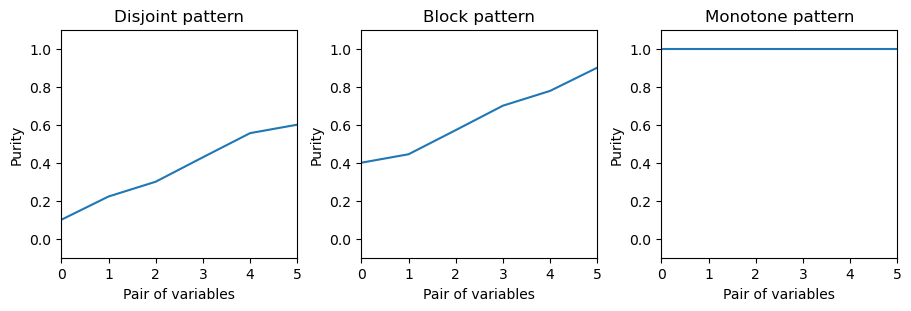

In [8]:
purities = [df_patterns[df_patterns['Pattern'] == i]['Purity'] for i in mdu.PATTERNS]
names = [i.capitalize() + ' pattern' for i in mdu.PATTERNS]

ax_kw = {'ylim': (-0.1, 1.1), 'title': names}
fig_kw = {'size_inches': (9, 3), 'constrained_layout': True}
mdp.plot_purity_of_patterns(purities, perceptual_threshold=None, fig_kw=fig_kw, ax_kw=ax_kw)

### Indicate the most pure pattern for each pair of variables

The heatmap shows that every pair of variables has a pure monotone pattern of missingness.

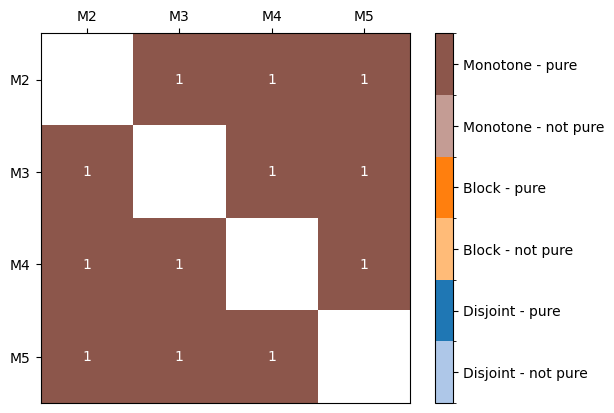

In [9]:
mdp.plot_purity_heatmap(df_patterns, datalabels=True)

## Explanation graph

### Initialise the graph

In [10]:
graph = eg.Explanation_Graph(intersection_id_to_columns, intersection_cardinality, criteria=eg.CHECK_COLUMNS)

### Add a node for the monotone pattern

In [11]:
dfs = df_patterns[df_patterns['Purity']>=1.0]
# Get the variable in each column
cols = list(dfs['Column1'].values) + list(dfs['Column2'].values)
intersections = graph.get_intersections(cols)

caption = 'Monotone'
description = 'Variables M1, M2, M3 and M4 have a monotone pattern of missingness.'
graph.add_node(eg.Explanation_Node(cols, intersections, caption, description))

DFS, node 1 parents []


### Visualize the explanation graph

The Root node is created automatically. Nodes may be customised by changing shape, colour and other attributes. Node positions may be modified by function calls.

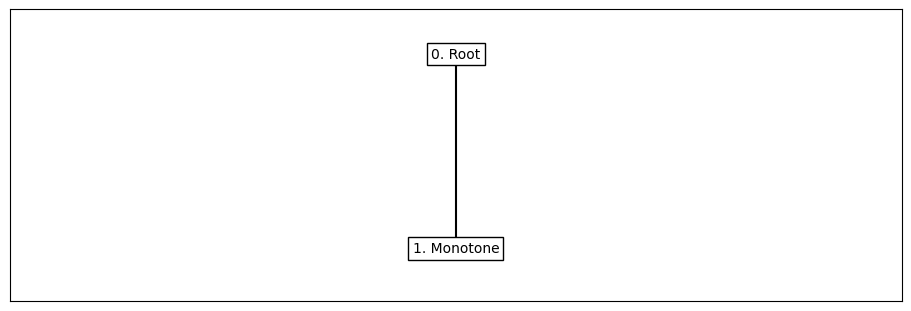

In [12]:
mdp.plot_explanation_graph_diagram(graph, fig_kw=fig_kw)

## Summary of explanations

The graph summary shows the percentage of intersections (i.e., combinations of missing values), rows, columns and missing values that are completely, partly or not explained by the current graph. The summary below confirms that all of those aspects of missingness are completely explained (i.e., nothing has accidentally omitted).

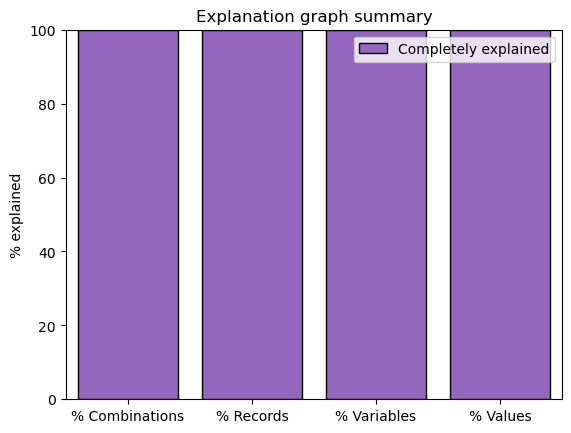

In [13]:
df_summ = graph.get_summary()
mdp.plot_explanation_graph_summary(df_summ)